<a href="https://colab.research.google.com/github/beltranbot/CodeDeployGitHubDemo/blob/master/Sesi%C3%B3n_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árboles de decisión y bosques aleatorios
## Decision Trees and Random Forests

Aquí repasaremos el algoritmo no paramétrico llamado *bosques aleatorios*.

Los bosques aleatorios o "Random Forest" son un ejemplo de un método de *conjunto* o *ensemble*, lo que significa que se basan en agregar los resultados de un conjunto de estimadores más simples.

El sorprendente resultado de tales métodos de *ensemble* es que la suma puede ser mayor que las partes: es decir, ¡un voto mayoritario entre varios estimadores puede terminar siendo mejor que cualquiera de los estimadores individuales que votan!

**¡Manos a la obra!**

Comenzamos con los import más comunes.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Random forests son un ejemplo de un *ensemble learner*, el cual se construye sobre árboles de decisión. Como su base son estos últimos, es el primer elemento que se debe definir.

Los *Decision trees* son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente define un conjunto de preguntas diseñadas para obtener una clasificación.

Suponed que quiere crear un árbol de decisiones para clasificar un animal que econtráis en el parque. El árbol de preguntas que podéis definir puede ser el siguiente:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá la cantidad de opciones a aproximadamente la mitad, reduciendo muy rápidamente las opciones incluso entre una gran cantidad de **clases**.

**¿Dónde está el truco?**

El truco está en decidir qué preguntas hacer en cada paso.
En las implementaciones de aprendizaje automático de los árboles de decisión, las preguntas generalmente toman la forma de divisiones que se alinean con el eje en los datos: es decir, cada nodo en el árbol divide los datos en dos grupos usando un *valor de corte* dentro de una de las características.

### Crearemos un árbol de decisión

Considera que cuentas con los siguientes datos bidimensionales, los cuales poseen cuatro etiquetas de clase:

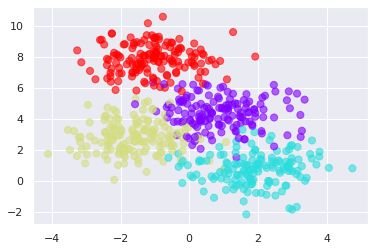

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=600, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', alpha=0.6);

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje de acuerdo con algún criterio *cuantitativo*, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con el *voto mayoritario* de los puntos dentro de ella.

Observa la figura e intenta interpretar los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/mfcardenas/Recursos/blob/main/img_01_DT-L_2.png?raw=1)



Si observas el gráfico anterior, después del primer corte (paso 1), todos los puntos de la rama superior permanecen sin cambios. En esta parte no es necesario seguir haciendo cortes o subdivisiones (nos queda una rama clara del árbol).

A excepción de los nodos que contienen puntos de un mismo color, en cada nivel *todas* las regiones se dividen nuevamente a lo largo de una de las dos características.

Este proceso de ajustar un árbol de decisión a nuestros datos se puede hacer en Python mediante la librería **Scikit-Learn**, con el estimador ``DecisionTreeClassifier``:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Como buen Data Science, ten a mano una función que ayude a pintar o visualizar la salida del clasificador:

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora comprueba que puedes examinar cómo se ve la clasificación del árbol de decisión:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


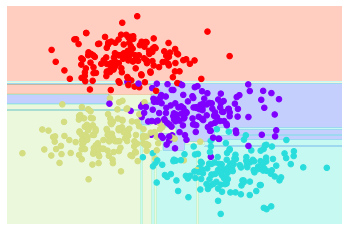

In [ ]:
visualize_classifier(DecisionTreeClassifier(), X, y)

**Importante**

A medida que aumenta la profundidad del árbol, se tiende a generar regiones de clasificación con formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y azul.
Está claro que esto es menos el resultado de la verdadera distribución de datos intrínseca y más el resultado de las propiedades particulares de muestreo o ruido de los datos.
Es decir, este árbol de decisiones, incluso con solo cinco niveles de profundidad, está claramente **sobreajustado** a nuestros datos.

### Decision trees y el over-fitting

Aquí va el pero... El *sobre-ajuste* es una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que se extraen.

Otra forma de ver este sobreajuste es mirar modelos entrenados en diferentes subconjuntos de datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales:

![](https://github.com/mfcardenas/Recursos/blob/main/img_02_DT-O_2.png?raw=1)

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

En algunas regiones, ambos árboles producen resultados consistentes (p. ej., en las cuatro esquinas), mientras que en otros lugares, cada árbol da clasificaciones muy diferentes (p. ej., en las regiones entre dos grupos).

Lo importante de observar este problema es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura.

**¿Cómo aprovechamos la potencia de los dos árboles?**
 
 > Usando la información de *ambos* árboles

 ¡A lo mejor podríamos obtener un mejor resultado!

> Así como el uso de información de dos árboles mejora los resultados, se podría esperar que el uso de información de muchos árboles mejoraría aún más los resultados.

## Ensembles of Estimators: Random Forests

Esta noción, en la que se pueden combinar múltiples estimadores de sobreajuste para reducir el efecto de este sobreajuste, es lo que subyace en un método de conjunto llamado *bagging*.

El embolsado o *bagging* utiliza un conjunto de estimadores paralelos, cada uno de los cuales sobreajusta los datos y promedia los resultados para encontrar una mejor clasificación.

Un conjunto de árboles de decisión aleatorios *randomized decision trees* se conoce como *random forest*.

**¿Y en Python esto como se lleva a cabo?**

Es posible usar el meta-estimador de Scikit-Learn's ``BaggingClassifier``:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


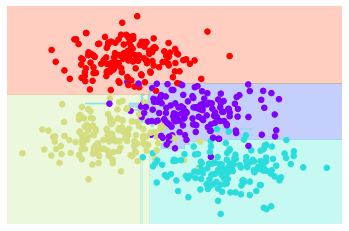

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En el ejemplo anterior, se han aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento.

En la práctica, los árboles de decisión se aleatorizan de manera más efectiva al inyectar algo de estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada.

Por ejemplo, al determinar en qué función dividir, el árbol aleatorio puede seleccionar entre las principales funciones.

Os recomiendo consultar más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn] (http://scikit-learn.org/stable/modules/ensemble.html#forest).

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa con ayuda del estimador ``RandomForestClassifier``, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesita hacer es seleccionar una cantidad de estimadores, y muy rápidamente (en paralelo, si lo desea) se ajustará al conjunto de árboles:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


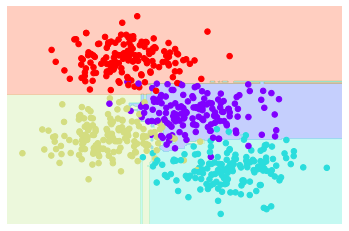

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Observa que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Random Forest Regression

En la sección anterior, consideramos *Random Forest* dentro del contexto de la clasificación. También es posible utilizarlos en casos de regresión (es decir, variables continuas en lugar de categóricas). 

El estimador a usar para este caso es ``RandomForestRegressor``, y la sintaxis es muy similar a la que vimos antes.

Considere los siguientes datos, extraídos de la combinación de una oscilación rápida y lenta:

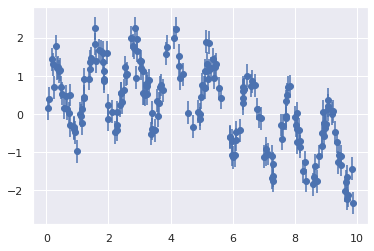

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

**¿Podríamos encontrar la curva que se mejor se ajuste a la de la gráfica?**

Sí, usando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera:

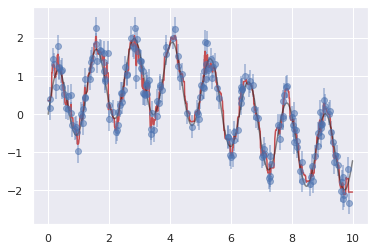

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)

forest.fit(x[:, None], y)
xfit = np.linspace(0, 10, 1000)

yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

El modelo real se muestra en la curva gris uniforme, mientras que el modelo del RF se muestra en la curva roja irregular.

**¿Por qué irregular?**

El modelo de RF no paramétrico es lo suficientemente flexible como para adaptarse a los datos de varios períodos

**¡Sin que tengamos que especificar un modelo de varios períodos!**

## Random Forest para clasificar Números

Utilice el dataset de dígitos que ofrece Sklearn.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Echa un vistazo al dataset antes de continuar:

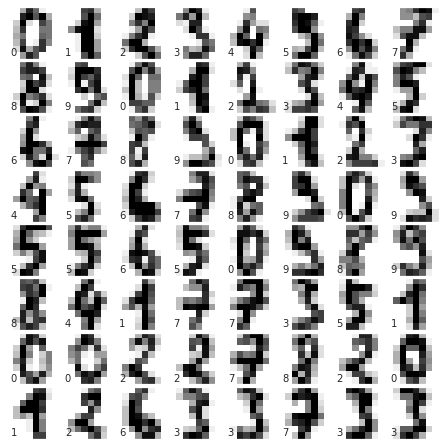

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

**¿Podemos clasificar estas imágenes con RF?**

*Podemos* clasificar rápidamente los dígitos usando un RF de la siguiente manera:

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

Revisa el informe de clasificación de este clasificador:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       0.98      1.00      0.99        51
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



No olvide dibujar la matriz de confusión:

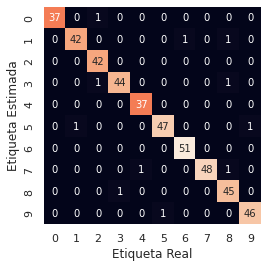

In [ ]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Etiqueta Real')
plt.ylabel('Etiqueta Estimada');

Encontramos que un RF simple da como resultado una clasificación muy precisa de los datos de dígitos.

## Algunas ideas antes de terminar la sesión

Este repaso te debe ayudar a introducirte en el mundo de los *estimadores de conjunto* y, en particular, al uso de Random Forest, un conjunto de árboles de decisión aleatorios.

**Ventajas de RF**

- Tanto el entrenamiento como la predicción son muy rápidos, debido a la simplicidad de los árboles de decisión subyacentes. 
- Ambas tareas se pueden paralelizar directamente, porque los árboles individuales son entidades totalmente independientes.
- Los árboles múltiples permiten una *clasificación probabilística*: un voto mayoritario entre los estimadores da una estimación de la probabilidad (se accede en Scikit-Learn con el método ``predict_proba()``).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas que otros estimadores no se ajustan bien.

**Desventajas de RF**

Una desventaja principal de RF es que los resultados no son fáciles de interpretar: es decir, si desea sacar conclusiones sobre el *significado* del modelo de clasificación, es posible que los bosques aleatorios no sean la mejor opción.